## 일자별 지하철 이용자수 (20년 이후)

### 1. csv merge

In [1]:
import pyspark

In [2]:
import pandas as pd
import glob
import os

input_file = r'./data2'
output_file = r'./data2/metro_per_date2.csv'

allFile_list = glob.glob(os.path.join(input_file, 'corona_*'))
print(allFile_list)
allData = []
for file in allFile_list:
    df = pd.read_csv(file, encoding='utf-8')
    allData.append(df)

dataCombine = pd.concat(allData, axis=0, ignore_index=True)
dataCombine.to_csv(output_file,encoding='utf-8', index=False)

['./data2\\corona_post1.csv', './data2\\corona_previous1.csv']


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.format("csv").option("header", True).load("./data2/metro_per_date2.csv", encoding='utf-8')

In [5]:
df.printSchema()

root
 |-- 사용일자: string (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: string (nullable = true)
 |-- 하차총승객수: string (nullable = true)
 |-- 등록일자: string (nullable = true)



In [6]:
df.show()

+--------+------------+--------------------+------------+------------+--------+
|사용일자|      노선명|                역명|승차총승객수|하차총승객수|등록일자|
+--------+------------+--------------------+------------+------------+--------+
|20200101|       1호선|                종각|     20427.0|     16301.0|20200104|
|20200101|       1호선|                시청|     12126.0|     10516.0|20200104|
|20200101|  우이신설선|              신설동|       892.0|       828.0|20200104|
|20200101|  우이신설선|                보문|       917.0|       855.0|20200104|
|20200101|  우이신설선|  성신여대입구(돈암)|      2010.0|      2363.0|20200104|
|20200101|  우이신설선|                정릉|      2096.0|      1989.0|20200104|
|20200101|  우이신설선|        북한산보국문|      2945.0|      2849.0|20200104|
|20200101|  우이신설선|                솔샘|      2477.0|      2272.0|20200104|
|20200101|  우이신설선|          삼양사거리|      1288.0|      1316.0|20200104|
|20200101|  우이신설선|                삼양|      1113.0|      1188.0|20200104|
|20200101|  우이신설선|                화계|      1789.0|      1690.0|

### 2. 데이터 전처리과정

In [7]:
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [8]:
#컬럼 데이터타입 변환
df = df.withColumn('사용일자',F.to_date(F.col("사용일자"),"yyyyMMdd"))\
.withColumn('승차총승객수',F.col('승차총승객수').cast(T.IntegerType()))\
.withColumn('하차총승객수',F.col('하차총승객수').cast(T.IntegerType()))

In [9]:
df.printSchema()

root
 |-- 사용일자: date (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: integer (nullable = true)
 |-- 하차총승객수: integer (nullable = true)
 |-- 등록일자: string (nullable = true)



In [10]:
df.show()

+----------+------------+--------------------+------------+------------+--------+
|  사용일자|      노선명|                역명|승차총승객수|하차총승객수|등록일자|
+----------+------------+--------------------+------------+------------+--------+
|2020-01-01|       1호선|                종각|       20427|       16301|20200104|
|2020-01-01|       1호선|                시청|       12126|       10516|20200104|
|2020-01-01|  우이신설선|              신설동|         892|         828|20200104|
|2020-01-01|  우이신설선|                보문|         917|         855|20200104|
|2020-01-01|  우이신설선|  성신여대입구(돈암)|        2010|        2363|20200104|
|2020-01-01|  우이신설선|                정릉|        2096|        1989|20200104|
|2020-01-01|  우이신설선|        북한산보국문|        2945|        2849|20200104|
|2020-01-01|  우이신설선|                솔샘|        2477|        2272|20200104|
|2020-01-01|  우이신설선|          삼양사거리|        1288|        1316|20200104|
|2020-01-01|  우이신설선|                삼양|        1113|        1188|20200104|
|2020-01-01|  우이신설선|                화

In [11]:
#Null 값 확인
df.where(F.col('하차총승객수').isNull()==True).count()

0

In [12]:
#이상치 확인
df.where(F.col('하차총승객수')<0).count()

0

In [13]:
#이용자 수 컬럼 생성(승차총승객수 + 하차총승객수)
df = df.withColumn('이용객수', sum([df[col] for col in ["`승차총승객수`","`하차총승객수`"]]))
df.show()

+----------+------------+--------------------+------------+------------+--------+--------+
|  사용일자|      노선명|                역명|승차총승객수|하차총승객수|등록일자|이용객수|
+----------+------------+--------------------+------------+------------+--------+--------+
|2020-01-01|       1호선|                종각|       20427|       16301|20200104|   36728|
|2020-01-01|       1호선|                시청|       12126|       10516|20200104|   22642|
|2020-01-01|  우이신설선|              신설동|         892|         828|20200104|    1720|
|2020-01-01|  우이신설선|                보문|         917|         855|20200104|    1772|
|2020-01-01|  우이신설선|  성신여대입구(돈암)|        2010|        2363|20200104|    4373|
|2020-01-01|  우이신설선|                정릉|        2096|        1989|20200104|    4085|
|2020-01-01|  우이신설선|        북한산보국문|        2945|        2849|20200104|    5794|
|2020-01-01|  우이신설선|                솔샘|        2477|        2272|20200104|    4749|
|2020-01-01|  우이신설선|          삼양사거리|        1288|        1316|20200104|    2604|
|2020-01

In [14]:
#필요없는 컬럼 제거
df = df.drop('등록일자')
df.show()

+----------+------------+--------------------+------------+------------+--------+
|  사용일자|      노선명|                역명|승차총승객수|하차총승객수|이용객수|
+----------+------------+--------------------+------------+------------+--------+
|2020-01-01|       1호선|                종각|       20427|       16301|   36728|
|2020-01-01|       1호선|                시청|       12126|       10516|   22642|
|2020-01-01|  우이신설선|              신설동|         892|         828|    1720|
|2020-01-01|  우이신설선|                보문|         917|         855|    1772|
|2020-01-01|  우이신설선|  성신여대입구(돈암)|        2010|        2363|    4373|
|2020-01-01|  우이신설선|                정릉|        2096|        1989|    4085|
|2020-01-01|  우이신설선|        북한산보국문|        2945|        2849|    5794|
|2020-01-01|  우이신설선|                솔샘|        2477|        2272|    4749|
|2020-01-01|  우이신설선|          삼양사거리|        1288|        1316|    2604|
|2020-01-01|  우이신설선|                삼양|        1113|        1188|    2301|
|2020-01-01|  우이신설선|                화

In [15]:
#9호선2~3단계를 9호선으로 변경
df = df.withColumn("노선명", F.when(df.노선명 == "9호선2~3단계","9호선").otherwise(df.노선명))
df = df.withColumn("노선명", F.when(df.노선명 == "9호선2단계","9호선").otherwise(df.노선명))
df.show()

+----------+----------+--------------------+------------+------------+--------+
|  사용일자|    노선명|                역명|승차총승객수|하차총승객수|이용객수|
+----------+----------+--------------------+------------+------------+--------+
|2020-01-01|     1호선|                종각|       20427|       16301|   36728|
|2020-01-01|     1호선|                시청|       12126|       10516|   22642|
|2020-01-01|우이신설선|              신설동|         892|         828|    1720|
|2020-01-01|우이신설선|                보문|         917|         855|    1772|
|2020-01-01|우이신설선|  성신여대입구(돈암)|        2010|        2363|    4373|
|2020-01-01|우이신설선|                정릉|        2096|        1989|    4085|
|2020-01-01|우이신설선|        북한산보국문|        2945|        2849|    5794|
|2020-01-01|우이신설선|                솔샘|        2477|        2272|    4749|
|2020-01-01|우이신설선|          삼양사거리|        1288|        1316|    2604|
|2020-01-01|우이신설선|                삼양|        1113|        1188|    2301|
|2020-01-01|우이신설선|                화계|        1789|        1690|

In [16]:
#공항철도 1호선을 공항철도로 변경
df = df.withColumn("노선명", F.when(df.노선명 == "공항철도 1호선","공항철도").otherwise(df.노선명))
df.show()

+----------+----------+--------------------+------------+------------+--------+
|  사용일자|    노선명|                역명|승차총승객수|하차총승객수|이용객수|
+----------+----------+--------------------+------------+------------+--------+
|2020-01-01|     1호선|                종각|       20427|       16301|   36728|
|2020-01-01|     1호선|                시청|       12126|       10516|   22642|
|2020-01-01|우이신설선|              신설동|         892|         828|    1720|
|2020-01-01|우이신설선|                보문|         917|         855|    1772|
|2020-01-01|우이신설선|  성신여대입구(돈암)|        2010|        2363|    4373|
|2020-01-01|우이신설선|                정릉|        2096|        1989|    4085|
|2020-01-01|우이신설선|        북한산보국문|        2945|        2849|    5794|
|2020-01-01|우이신설선|                솔샘|        2477|        2272|    4749|
|2020-01-01|우이신설선|          삼양사거리|        1288|        1316|    2604|
|2020-01-01|우이신설선|                삼양|        1113|        1188|    2301|
|2020-01-01|우이신설선|                화계|        1789|        1690|

In [17]:
#전처리 확인
df.select('노선명').distinct().collect()

[Row(노선명='일산선'),
 Row(노선명='장항선'),
 Row(노선명='경부선'),
 Row(노선명='우이신설선'),
 Row(노선명='분당선'),
 Row(노선명='7호선'),
 Row(노선명='수인선'),
 Row(노선명='안산선'),
 Row(노선명='4호선'),
 Row(노선명='1호선'),
 Row(노선명='경의선'),
 Row(노선명='3호선'),
 Row(노선명='경강선'),
 Row(노선명='경춘선'),
 Row(노선명='9호선'),
 Row(노선명='6호선'),
 Row(노선명='5호선'),
 Row(노선명='8호선'),
 Row(노선명='공항철도'),
 Row(노선명='과천선'),
 Row(노선명='경인선'),
 Row(노선명='중앙선'),
 Row(노선명='2호선'),
 Row(노선명='경원선')]

In [18]:
#parquet파일 저장
df.write.parquet('metro_per_date')

### 3. 데이터 분석과정

In [19]:
pq = spark.read.parquet('metro_per_date')
pq.show()

+----------+------+------------+------------+------------+--------+
|  사용일자|노선명|        역명|승차총승객수|하차총승객수|이용객수|
+----------+------+------------+------------+------------+--------+
|2018-01-10|분당선|압구정로데오|       16346|       18420|   34766|
|2018-01-10|분당선|      서울숲|        7914|        7922|   15836|
|2018-01-10|분당선|        수원|        9461|        6280|   15741|
|2018-01-10|분당선|        수서|       15403|       15627|   31030|
|2018-01-10|분당선|  대모산입구|        3431|        3182|    6613|
|2018-01-10|분당선|      개포동|        3582|        3723|    7305|
|2018-01-10|분당선|        구룡|        2105|        2005|    4110|
|2018-01-10|분당선|        도곡|        7855|        8147|   16002|
|2018-01-10|분당선|        한티|       16276|       17214|   33490|
|2018-01-10|분당선|        선릉|       10792|       22141|   32933|
|2018-01-10|과천선|        범계|       32318|       30961|   63279|
|2018-01-10|과천선|        평촌|       19691|       19258|   38949|
|2018-01-10|과천선|      인덕원|       28817|       28564|   57381|
|2018-01-10|

In [20]:
pq.schema

StructType(List(StructField(사용일자,DateType,true),StructField(노선명,StringType,true),StructField(역명,StringType,true),StructField(승차총승객수,IntegerType,true),StructField(하차총승객수,IntegerType,true),StructField(이용객수,IntegerType,true)))

In [21]:
pq.count()

809443

In [22]:
#일별이용자수를 그래프로 나타냄
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
df.groupby('`사용일자`').agg(F.sum('`승차총승객수`').alias('일별이용자수')).orderBy(F.desc('`사용일자`')).show()

+----------+------------+
|  사용일자|일별이용자수|
+----------+------------+
|2021-09-30|     6398703|
|2021-09-29|     6069925|
|2021-09-28|     6290961|
|2021-09-27|     6283331|
|2021-09-26|     3092457|
|2021-09-25|     4268559|
|2021-09-24|     6308669|
|2021-09-23|     5926216|
|2021-09-22|     2844480|
|2021-09-21|     1909182|
|2021-09-20|     2388026|
|2021-09-19|     2951063|
|2021-09-18|     4070548|
|2021-09-17|     6524487|
|2021-09-16|     6448207|
|2021-09-15|     6460104|
|2021-09-14|     6335834|
|2021-09-13|     6268263|
|2021-09-12|     3247734|
|2021-09-11|     4477493|
+----------+------------+
only showing top 20 rows



In [23]:
user_per_date = df.groupby('`사용일자`').agg(F.sum('`승차총승객수`').alias('일별이용자수')).orderBy(F.asc('`사용일자`'))

In [24]:
user_per_date = user_per_date.select("*").toPandas()

In [25]:
user_per_date

,사용일자,일별이용자수
0,2018-01-01,3520929
1,2018-01-02,7505016
2,2018-01-03,7681469
3,2018-01-04,7705415
4,2018-01-05,8134256
...,...,...
1364,2021-09-26,3092457
1365,2021-09-27,6283331
1366,2021-09-28,6290961
1367,2021-09-29,6069925


###  4. 그래프 확인

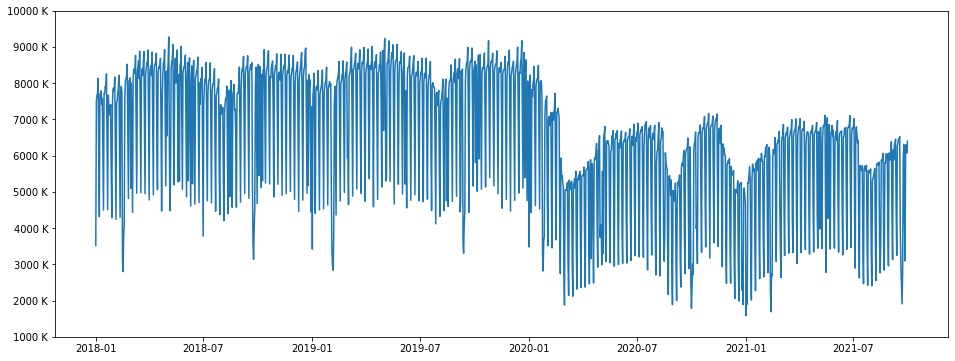

In [26]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(user_per_date.사용일자, user_per_date.일별이용자수/1000, label='expoential')

plt.ylim([1000, 10000])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i K'))
leg = plt.legend()
ax.get_legend().remove()

plt.show() 